In [1]:
import geopandas as gpd
from tqdm import tqdm
import libpysal as lp
import json
import pandas as pd

###  Get the data in the folder ./LCPS_data for pre-processing. Let's call this `retrieved data`.

In [53]:
def retrieve_data(sy):
    """
    Retrieve data for a given school year (sy)
    """
    data_dir = "./LCPS_data"
    # Read the data files
    schools = gpd.read_file('{}/LCPS_Sites_{}.shp'.format(data_dir, sy))
    students = gpd.read_file('{}/Students_{}.shp'.format(data_dir, sy))
    spas = gpd.read_file('{}/PlanningZones_{}.shp'.format(data_dir, sy))
    
    return schools, students, spas


In [54]:
sy = '2017_2018'

In [55]:
raw_schools, raw_students, raw_spas = retrieve_data(sy)

###  Get the processed data from the folder ./data

In [72]:
spas = gpd.read_file('./data/new_SPAs_2017_2018.json', driver='GeoJSON')
students = gpd.read_file('./data/new_Students_2017_2018.json', driver='GeoJSON')
schools = gpd.read_file('./data/new_Schools_2017_2018.json', driver='GeoJSON')

#new line to run the newly downloaded json files, should move around anywhere.

In [159]:
#students.head()
#schools.head()
spas.head()

#uncomment the one you want to see

,OBJECTID,COUNT_,SPA,ELEM_,INT_,HIGH_,ELEM_CODE,MID_CODE,HIGH_CODE,DISTRICT,...,HIGH_POP_N,HIGH_POP_P,TOT_POP_A,TOT_POP_W,TOT_POP_M2,TOT_POP_B,TOT_POP_H,TOT_POP_N,TOT_POP_P,geometry
0,1,5.0,WL03.4,126,205,311,LOV,HRM,WHS,WL,...,0,0,1,37,0,2,7,0,0,"POLYGON ((11725868.086 7152149.054, 11725870.6..."
1,2,5.0,WL03,126,205,311,LOV,HRM,WHS,WL,...,0,0,0,83,5,0,6,1,0,"POLYGON ((11726805.147 7160565.439, 11726826.6..."
2,3,5.0,WL27.2,118,202,305,HAM,BRM,LVH,WL,...,0,0,0,11,0,1,5,0,0,"POLYGON ((11720159.464 7099502.139, 11720172.1..."
3,4,5.0,WL32.1,132,205,311,MTV,HRM,WHS,WL,...,0,0,8,205,14,8,23,1,0,"POLYGON ((11694466.485 7097608.657, 11694418.5..."
4,5,5.0,WL02,126,205,311,LOV,HRM,WHS,WL,...,0,0,9,170,3,0,5,0,0,"POLYGON ((11715899.154 7166497.655, 11715932.1..."


In [ ]:
## Attempted Analysis Using Students Data ()

###  Student  Ethnic distributions over districts

In [160]:
# To get the necessary columns from the students dataframe use (needed_ethnicities)
needed_ethnicities = students[["ObjectID", "ETHNIC","ELEM_CODE"]]


In [61]:
# To group the students by their districts and ethnicities and count the  number in each group

grouped_data = needed_ethnicities.groupby(['ELEM_CODE', 'ETHNIC']).count()
grouped_data

#this displays all headers I want to see
# grouped_data.columns

In [164]:
denominators = needed_ethnicities.groupby(['ELEM_CODE']).count()


In [165]:
# school_codes = needed_ethnicities.ELEM_CODE.unique()
# #len(needed_ethnicities.ELEM_CODE.unique())


# for code in school_codes:
#      if code is not None:
        
#         print("\n", code)
#         #denominators=needed_ethnicities.groupby(['ELEM_CODE']).count()
#         school_percentage = grouped_data.loc[code]/denominators.loc[code]["ETHNIC"]
#         print(school_percentage)

In [185]:
ethnicities_result = (grouped_data[["ObjectID"]]/denominators)
ethnicities_result = ethnicities_result.drop('ETHNIC',axis=1)
ethnicities_result.rename(columns={"ObjectID":"Percentages"}, inplace=True)
ethnicities_result
#print(denominators) 368x2 columns
#print(grouped_data) 368x1 columns

#sum_denominators = needed_ethnicities.groupby(['ELEM_CODE']).sum()
#print(sum_denominators)

Percentages
ELEM_CODE ETHNIC             
ALD       A          0.083130
          B          0.073350
          H          0.156479
          M2         0.068460
          N          0.002445
...                       ...
WAT       B          0.027368
          H          0.040000
          M2         0.044211
          N          0.004211
          W          0.840000

[368 rows x 1 columns]

In [64]:
# type(ethnicities_result)
#print(ethnicities_result).transform('min')
#ethnicities_summary = ethnicities_result.agg({'ObjectID': ['min', 'max']})
  
#print(" min, and max values of ethnicities_summary")
#print(ethnicities_summary)
#trying to print all min and max values in a school to help me make a threshold decision to build a suitable metric

pandas.core.frame.DataFrame

### Ethnic distributions over the entire region

In [65]:
baselines = students.groupby("ETHNIC").count()["ObjectID"]/len(students)
baselines

ETHNIC
A     0.213369
B     0.067054
H     0.172486
M2    0.053655
N     0.005133
P     0.001093
W     0.487209
Name: ObjectID, dtype: float64

In [169]:
# ethnicities_result.loc[("BAN",),'ObjectID' ]
#  < baselines

In [186]:
# Comparison of one district (ALD) to the regional distribution
comparison_result = ethnicities_result.loc[('ALD', ),'Percentages' ] <= baselines
measurement_metric = sum(comparison_result)
print ("The underrepresented groups in this district is", measurement_metric)
baselines[comparison_result]


The underrepresented groups in this school is 3


ETHNIC
A    0.213369
H    0.172486
N    0.005133
Name: ObjectID, dtype: float64

In [182]:
ethnicities_result.index
# ethnicities_result.index.unique("ELEM_CODE")

MultiIndex([('ALD',  'A'),
            ('ALD',  'B'),
            ('ALD',  'H'),
            ('ALD', 'M2'),
            ('ALD',  'N'),
            ('ALD',  'P'),
            ('ALD',  'W'),
            ('ALG',  'A'),
            ('ALG',  'B'),
            ('ALG',  'H'),
            ...
            ('TOL', 'M2'),
            ('TOL',  'N'),
            ('TOL',  'P'),
            ('TOL',  'W'),
            ('WAT',  'A'),
            ('WAT',  'B'),
            ('WAT',  'H'),
            ('WAT', 'M2'),
            ('WAT',  'N'),
            ('WAT',  'W')],
           names=['ELEM_CODE', 'ETHNIC'], length=368)

In [189]:
for elem_code in ethnicities_result.index.unique("ELEM_CODE"):
    print(elem_code)
    print(ethnicities_result.loc[(elem_code, ), 'Percentages'])
    
#     comparison_result = ethnicities_result.loc[(elem_code, ),'Percentages' ] <= baselines
#     measurement_metric = sum(comparison_result)
#     print ("The underrepresented groups in this district is", measurement_metric)
#     baselines[comparison_result]


ALD
ETHNIC
A     0.083130
B     0.073350
H     0.156479
M2    0.068460
N     0.002445
P     0.004890
W     0.611247
Name: Percentages, dtype: float64
ALG
ETHNIC
A     0.083257
B     0.055810
H     0.145471
M2    0.060384
N     0.003660
P     0.001830
W     0.649588
Name: Percentages, dtype: float64
ARC
ETHNIC
A     0.359041
B     0.088588
H     0.096925
M2    0.069307
N     0.004169
P     0.001563
W     0.380406
Name: Percentages, dtype: float64
ASH
ETHNIC
A     0.191717
B     0.079492
H     0.146961
M2    0.055444
N     0.003340
P     0.000668
W     0.522378
Name: Percentages, dtype: float64
BAL
ETHNIC
A     0.106452
B     0.083226
H     0.207742
M2    0.062581
N     0.006452
P     0.003226
W     0.530323
Name: Percentages, dtype: float64
BAN
ETHNIC
A     0.012007
B     0.075472
H     0.188679
M2    0.034305
N     0.003431
W     0.686106
Name: Percentages, dtype: float64
BST
ETHNIC
A     0.169823
B     0.061869
H     0.091540
M2    0.066288
N     0.003788
P     0.000631
W     0.606061

## Analysis Using New SPAs Data

In [80]:
spas.keys()

Index(['OBJECTID', 'COUNT_', 'SPA', 'ELEM_', 'INT_', 'HIGH_', 'ELEM_CODE',
       'MID_CODE', 'HIGH_CODE', 'DISTRICT', 'UTILITIES', 'SHAPE_Leng',
       'SHAPE_Area', 'STDYAREA_1', 'DISTRICT_1', 'PLANNING_Z', 'ELEM', 'MID',
       'HIGH', 'UTILITIE_1', 'DISTRICT_2', 'MID_2018', 'HIGH_2018', 'PK', 'KG',
       'GR1', 'GR2', 'GR3', 'GR4', 'GR5', 'GR6', 'GR7', 'GR8', 'GR9', 'GR10',
       'GR11', 'GR12', 'TOTAL_KG_5', 'TOTAL_6_8', 'TOTAL_9_12', 'TOTAL_KG_1',
       'TOTAL_PK_1', 'ELEM_POP', 'MID_POP', 'HIGH_POP', 'TOT_POP',
       'ELEM_POP_A', 'ELEM_POP_W', 'ELEM_POP_M2', 'ELEM_POP_B', 'ELEM_POP_H',
       'ELEM_POP_N', 'ELEM_POP_P', 'MID_POP_A', 'MID_POP_W', 'MID_POP_M2',
       'MID_POP_B', 'MID_POP_H', 'MID_POP_N', 'MID_POP_P', 'HIGH_POP_A',
       'HIGH_POP_W', 'HIGH_POP_M2', 'HIGH_POP_B', 'HIGH_POP_H', 'HIGH_POP_N',
       'HIGH_POP_P', 'TOT_POP_A', 'TOT_POP_W', 'TOT_POP_M2', 'TOT_POP_B',
       'TOT_POP_H', 'TOT_POP_N', 'TOT_POP_P', 'geometry'],
      dtype='object')

In [158]:
spas_ethnic = spas[['ELEM_CODE', 'ELEM_POP_A', 'ELEM_POP_W', 'ELEM_POP_M2', 'ELEM_POP_B', 'ELEM_POP_H',
       'ELEM_POP_N', 'ELEM_POP_P',]]
spas_grouped = spas_ethnic.groupby(['ELEM_CODE']).sum()
spas_grouped.head()


#when generalizing one place to change and use the FORMAT style

,ELEM_POP_A,ELEM_POP_W,ELEM_POP_M2,ELEM_POP_B,ELEM_POP_H,ELEM_POP_N,ELEM_POP_P
ELEM_CODE,,,,,,,
ALD,18,117,18,9,34,0,0
ALG,32,290,34,20,74,2,1
ARC,354,367,72,77,84,7,1
ASH,130,298,43,45,90,0,1
BAL,53,342,31,56,128,4,4


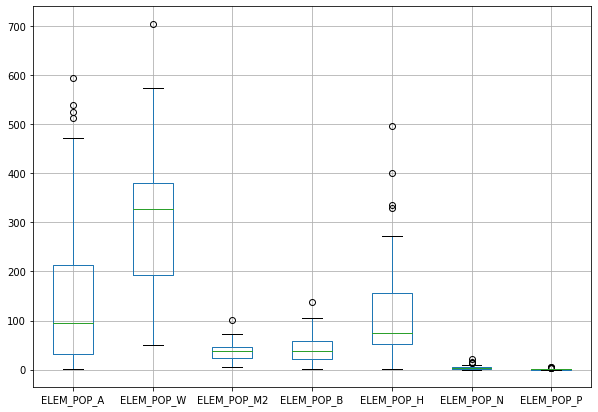

In [117]:
ax, props = spas_grouped.boxplot(column=['ELEM_POP_A', 'ELEM_POP_W', 'ELEM_POP_M2', 'ELEM_POP_B', 'ELEM_POP_H',
       'ELEM_POP_N', 'ELEM_POP_P'], figsize=(10,7), labels=['A', 'W', 'M2', 'B', 'H', 'N', 'P'], return_type='both')


In [126]:
outliers = [flier.get_ydata() for flier in props["fliers"]]
# boxes = [box.get_ydata() for box in props["boxes"]]
# medians = [median.get_ydata() for median in props["medians"]]
# whiskers = [whiskers.get_ydata() for whiskers in props["whiskers"]]

print(outliers)
#print(boxes)
# print(whiskers)

[array([526, 595, 512, 539], dtype=int64), array([705], dtype=int64), array([102], dtype=int64), array([138], dtype=int64), array([496, 329, 400, 336], dtype=int64), array([14, 22, 14, 15], dtype=int64), array([4, 5, 3, 3, 5, 3], dtype=int64)]


In [152]:
A_outliers = spas_grouped['ELEM_POP_A'].isin(outliers[0])
W_outliers = spas_grouped['ELEM_POP_W'].isin(outliers[1])
M2_outliers = spas_grouped['ELEM_POP_M2'].isin(outliers[2])
B_outliers = spas_grouped['ELEM_POP_B'].isin(outliers[3])
H_outliers = spas_grouped['ELEM_POP_H'].isin(outliers[4])
N_outliers = spas_grouped['ELEM_POP_N'].isin(outliers[5])
P_outliers = spas_grouped['ELEM_POP_P'].isin(outliers[6])

# outliers[0].contain(526)
spas_grouped[A_outliers]

,ELEM_POP_A,ELEM_POP_W,ELEM_POP_M2,ELEM_POP_B,ELEM_POP_H,ELEM_POP_N,ELEM_POP_P
ELEM_CODE,,,,,,,
BUF,526,705,102,138,109,14,5
CCE,595,254,55,59,58,22,1
LIB,512,381,46,77,74,7,2
RLC,539,171,45,60,50,9,3


In [147]:
spas_grouped[W_outliers]

,ELEM_POP_A,ELEM_POP_W,ELEM_POP_M2,ELEM_POP_B,ELEM_POP_H,ELEM_POP_N,ELEM_POP_P
ELEM_CODE,,,,,,,
BUF,526,705,102,138,109,14,5


In [148]:
spas_grouped[M2_outliers]

,ELEM_POP_A,ELEM_POP_W,ELEM_POP_M2,ELEM_POP_B,ELEM_POP_H,ELEM_POP_N,ELEM_POP_P
ELEM_CODE,,,,,,,
BUF,526,705,102,138,109,14,5


In [149]:
spas_grouped[B_outliers]

,ELEM_POP_A,ELEM_POP_W,ELEM_POP_M2,ELEM_POP_B,ELEM_POP_H,ELEM_POP_N,ELEM_POP_P
ELEM_CODE,,,,,,,
BUF,526,705,102,138,109,14,5


In [153]:
spas_grouped[H_outliers]

,ELEM_POP_A,ELEM_POP_W,ELEM_POP_M2,ELEM_POP_B,ELEM_POP_H,ELEM_POP_N,ELEM_POP_P
ELEM_CODE,,,,,,,
GUI,51,51,14,24,496,4,0
RRD,79,91,23,51,329,5,0
SUG,69,83,21,39,400,1,0
SUL,41,51,12,15,336,4,0


In [154]:
spas_grouped[N_outliers]

,ELEM_POP_A,ELEM_POP_W,ELEM_POP_M2,ELEM_POP_B,ELEM_POP_H,ELEM_POP_N,ELEM_POP_P
ELEM_CODE,,,,,,,
BUF,526,705,102,138,109,14,5
CCE,595,254,55,59,58,22,1
CRE,471,293,42,55,59,14,2
MTE,426,372,47,41,67,15,0


In [155]:
spas_grouped[P_outliers]

,ELEM_POP_A,ELEM_POP_W,ELEM_POP_M2,ELEM_POP_B,ELEM_POP_H,ELEM_POP_N,ELEM_POP_P
ELEM_CODE,,,,,,,
BAL,53,342,31,56,128,4,4
BUF,526,705,102,138,109,14,5
DIS,282,314,58,74,107,5,3
FOR,124,115,17,33,272,3,3
MSE,408,290,49,58,70,3,5
RLC,539,171,45,60,50,9,3


In [156]:
# cnt = 0
# for letter in ['A', 'W']:
#     spec_outliers = spas_grouped['ELEM_POP_{}'.format(letter)].isin(outliers[cnt])
#     print(spas_grouped[spec_outliers])
#     cnt += 1

In [ ]:
### What is happening with BUF? There is evidence that there could be a lot of segregation in this district. Could it be that their number of students is a factor?

In [108]:
spas_grouped.describe()

,ELEM_POP_A,ELEM_POP_W,ELEM_POP_M2,ELEM_POP_B,ELEM_POP_H,ELEM_POP_N,ELEM_POP_P
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,154.963636,304.145455,37.890909,42.490909,116.290909,4.054545,0.927273
std,162.741896,139.815145,17.824944,28.352198,101.723240,4.313708,1.259843
min,1.000000,51.000000,5.000000,1.000000,1.000000,0.000000,0.000000
25%,32.500000,192.500000,24.500000,22.500000,52.500000,1.000000,0.000000
50%,95.000000,328.000000,38.000000,37.000000,74.000000,3.000000,1.000000
75%,214.000000,381.000000,47.000000,58.500000,156.500000,5.000000,1.000000
max,595.000000,705.000000,102.000000,138.000000,496.000000,22.000000,5.000000


In [157]:
# import matplotlib.pyplot as plt
# from matplotlib.cbook import boxplot_stats

# stats = boxplot_stats(spas_grouped.values)
# stats

### What is happening with BUF?
There is evidence that there could be a lot of segregation in this district. Could it be that their number of students is a factor?

In [1]:
buf_zones = spas['ELEM_CODE'] == 'BUF'
buf_spas = spas[buf_zones]
# buf_spas

NameError: name 'spas' is not defined

In [ ]:
# ax, props = buf_spas.boxplot(column=['{}_POP_A'.format(grade), '{}_POP_W'.format(grade), '{}_POP_M2'.format(grade),\
#                                         '{}_POP_B'.format(grade), '{}_POP_H'.format(grade), '{}_POP_N'.format(grade), '{}_POP_P'.format(grade)],
#                                         figsize=(12,8), labels=['A', 'W', 'M2', 'B', 'H', 'N', 'P'], return_type='both')


In [ ]:
buf_spas_needed = buf_spas[['{}_POP_A'.format(grade) , '{}_POP_W'.format(grade) , '{}_POP_M2'.format(grade) ,\
             '{}_POP_B'.format(grade) , '{}_POP_H'.format(grade) , '{}_POP_N'.format(grade) , '{}_POP_P'.format(grade)]]
buf_spas_percentages = buf_spas_needed.div(buf_spas['ELEM_POP'], axis=0, fill_value= None)
buf_spas_percentages.replace(float('NaN'), 0, inplace= True)
# buf_spas_percentages

In [ ]:
# buf_spas_percentages.iloc[0,:] > baselines